In [1]:
# import dask and other packages for data analysis
import xarray as xr
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib import gridspec
from eofs.standard import Eof

/Users/planetkevin/opt/anaconda3/envs/PRI/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


### Part 1:
- Create a dataset that contains the monthly mean sea-surface temperature anomalies and precipitation anomalies over the Pacific basin. The land regions should be masked out. 

We'll extract the land-sea mask first. 

In [2]:
base_url1 = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.invariant/197901/'
base_url2 = 'e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc'

# open land-sea mask dataset - defined on a single time step
lsm = xr.open_dataset(base_url1+base_url2).sel(latitude=slice(65, -65), longitude=slice(120, 300))['LSM']

In [3]:
# let's see what it looks like
lsm

<xarray.DataArray 'LSM' (time: 1, latitude: 521, longitude: 721)>
[375641 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01
Attributes: (12/15)
    long_name:                     Land-sea mask
    short_name:                    lsm
    units:                         (0-1)
    original_format:               WMO GRIB 1 with ECMWF local table
    ecmwf_local_table:             128
    ecmwf_parameter:               172
    ...                            ...
    rda_dataset:                   ds633.0
    rda_dataset_url:               https:/rda.ucar.edu/datasets/ds633.0/
    rda_dataset_doi:               DOI: 10.5065/BH6N-5N20
    rda_dataset_group:             ERA5 atmospheric invariant fields [netCDF4]
    number_of_significant_digits:  7
    _ChunkSizes:                   [   1  721 1440]

Next, the total precipitation and sea-surface temperature

In [4]:
base_url = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/'

# period of interest
pr = pd.date_range(start='1979-01',end='2021-12', freq='AS')

# file name extensions
ext_pr = ['e5.moda.fc.sfc.accumu/', '/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.']
ext_sst = ['e5.moda.an.sfc/', '/e5.moda.an.sfc.128_034_sstk.ll025sc.']

# initialize empty file list for each variable
file_list_pr = []
file_list_sst = []

for yr in pr:
    # get recent year and month
    year = yr.strftime('%Y')
    date = yr.strftime('%Y%m%d%H')
    date2 = (yr + pd.DateOffset(months=11)).strftime('%Y%m%d%H')

    # build complete file name for each variable
    file_pr = (base_url+ext_pr[0]+year+ext_pr[1]+date+'_'+date2+'.nc')
    file_sst = (base_url+ext_sst[0]+year+ext_sst[1]+date+'_'+date2+'.nc')
    
    file_list_pr.append(file_pr)
    file_list_sst.append(file_sst)

In [5]:
# open datasets for data variables
pr = xr.open_mfdataset(file_list_pr).sel(latitude=slice(65, -65), longitude=slice(120, 300))['TP']
sst = xr.open_mfdataset(file_list_sst).sel(latitude=slice(65, -65), longitude=slice(120, 300))['SSTK']

In [6]:
# let's take a look at one of the variables for reference
pr

<xarray.DataArray 'TP' (time: 516, latitude: 521, longitude: 721)>
dask.array<getitem, shape=(516, 521, 721), dtype=float32, chunksize=(12, 521, 721), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
Attributes: (12/15)
    long_name:                     Total precipitation
    short_name:                    tp
    units:                         m
    original_format:               WMO GRIB 1 with ECMWF local table
    ecmwf_local_table:             128
    ecmwf_parameter:               228
    ...                            ...
    rda_dataset:                   ds633.1
    rda_dataset_url:               https:/rda.ucar.edu/datasets/ds633.1/
    rda_dataset_doi:               DOI: 10.5065/P8GT-0R61
    rda_dataset_group:             ERA5 monthly mean atmospheric surface fore...
    number_of_significant_digits:  7
    _ChunkSizes:                   [  3 389 776]

In [7]:
# compute anomalies
sst_anom = sst - sst.mean(dim='time')
pr_anom = pr - pr.mean(dim='time')

#saving an un-masked version of the precip. anomalies for Part 6
pr_anom_nomask = pr_anom

# mask out grid points over land
ntime = len(sst.time)
abool = np.array([(lsm == 1).squeeze()]*ntime) #masking array
sst_anom = sst_anom.where(abool==False)
pr_anom = pr_anom.where(abool==False)

In [8]:
# save to NETCDF4 file
sst_anom.to_netcdf('sst.anom.monmean.nc')

In [9]:
pr_anom_nomask.to_netcdf('pr.nomsk.anom.monmean.nc')
pr_anom.to_netcdf('pr.mask.anom.monmean.nc')

### Part 2:
- The next step is to deseasonalize, detrend, and standardize the SST anomalies. 

In [40]:
#extracting at a coarser grid resolution to save memory
lat = np.arange(65, -66, -1)
lon = np.arange(120, 301, 1)

sst_a = xr.open_dataarray('sst.anom.monmean.nc').sel(latitude=lat, longitude=lon)

In [41]:
# deseasonalizing function
def deseasonalize(var_a):
    months = var_a.time.dt.month
    clim = var_a.groupby(months).mean(dim='time')
    var_as = (var_a.groupby(months) - clim)
    return  var_as, months

In [42]:
# detrending function
def detrend_dim(var_as, dim, deg=1):
    # detrend along a single dimension
    p = var_as.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(var_as[dim], p.polyfit_coefficients)
    var_asd = var_as - fit
    return var_asd

In [43]:
# and finally, standardizing function
def standardize(var_asd, months):
    clim_mn = var_asd.groupby(months).mean('time')
    clim_std = var_asd.groupby(months).std('time')

    var_asds = xr.apply_ufunc(lambda x, m, s: (x - m) / s,
                              var_asd.groupby(months), clim_mn, clim_std)
    return var_asds

In [44]:
# wrap these functions into a preprocessing function
def preprocess_mon(var_a):
    var_as, months = deseasonalize(var_a)
    var_asd = detrend_dim(var_as, 'time', 1)
    var_asds = standardize(var_asd, months)
    return var_asds

# find the monthly mean, detrended, deseasonalized, and standardized SST anomalies
sst_asds = preprocess_mon(sst_a)

In [45]:
# the long-term mean should be approximately zero
sst_asds.mean(dim=('time','latitude', 'longitude'))

<xarray.DataArray ()>
array(1.73572587e-17)

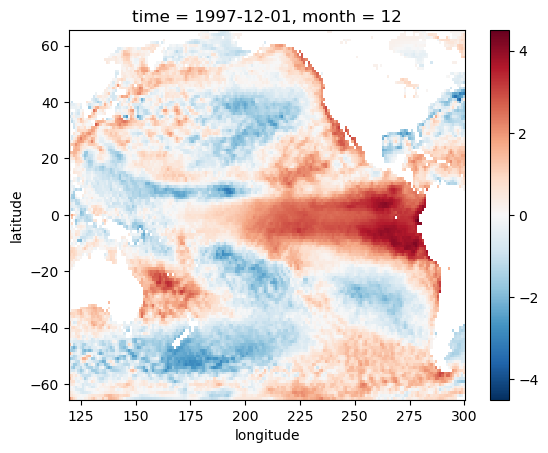

In [46]:
# further confirming the correctness of the resultant anomalies
# using an exceptionally large EL-Nino event
sst_asds.sel(time='1997-12-01').plot()

### Part 3:
- Perform an EOF analysis on cosine-weighted SST anomalies. 
- Plot a map of the first 5 EOFs. 

In [47]:
# cosine-weighting the standardized SST anomalies
lons, lats = np.meshgrid(sst_asds.coords['longitude'].values, sst_asds.coords['latitude'].values)
wgts = np.sqrt(np.cos(np.deg2rad(lats)))

In [48]:
# retrive 5 leading EOFs expressed as correlation
solver = Eof(sst_asds.to_numpy(), weights=wgts)
neofs = 5

eof0 = solver.eofsAsCorrelation(neofs=neofs)
pcs = solver.pcs(pcscaling=1, npcs=neofs)

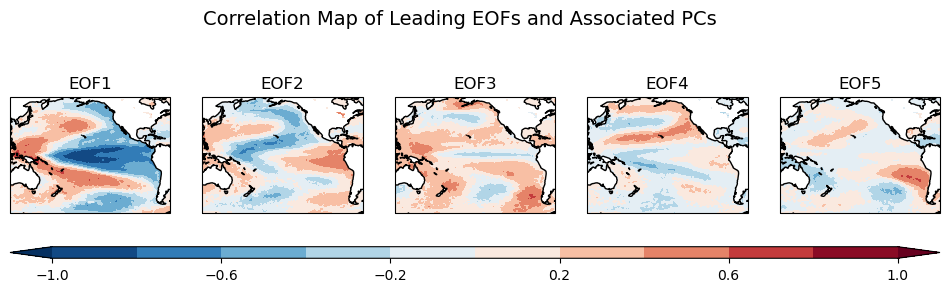

In [49]:
# plot the 5 leading EOFs
crs = ccrs.PlateCarree()
projection = ccrs.PlateCarree(central_longitude=180)
cmap = plt.get_cmap('RdBu_r')

levels = np.arange(-1, 1.2, .2)

xticks = np.arange(120, 320, 20)
yticks = np.arange(-60, 80, 20)

fig = plt.figure(figsize=(12,3))
gs = fig.add_gridspec(1, neofs)

fig.suptitle('Correlation Map of Leading EOFs and Associated PCs', fontsize=14)

axes = []
for k in range(neofs):
    ax = fig.add_subplot(gs[0, k], projection=projection)
    ax.add_feature(cfeature.COASTLINE)
    cf = ax.contourf(sst_asds.coords['longitude'].values, sst_asds.coords['latitude'].values, 
                     eof0[k,:,:], levels=levels, cmap=cmap, transform=crs, extend='both')
    ax.set_title('EOF'+str(k+1), fontsize=12)
    axes.append(ax)

left0, bottom0, width0, height = axes[0].get_position().bounds
left1, bottom1, width1, height = axes[-1].get_position().bounds
left = left0; width = (left1-left0)+width0

cbarax = fig.add_axes([left, 0.15, width, height*0.1])
cb = fig.colorbar(cf, cax=cbarax, orientation='horizontal', aspect=30, ticks=cf.levels[::2])

plt.show()

### Part 4:
- Plot the percent of variance explained by the first 10 EOFs. 

In [50]:
# fractional variance explained
var = solver.varianceFraction(neigs=10)
ind = np.arange(len(var))

In [51]:
# preparing plot labels
elabels = []
for i in range(len(var)):
    elabels.append('EOF'+str(i+1))

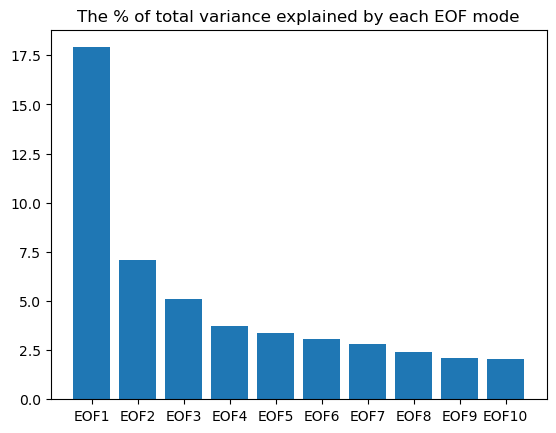

In [52]:
# plotting fractional variance of the first 10 EOF modes
fig, ax = plt.subplots()
b = ax.bar(ind, var*100) #expressed as a percentage
ax.set_xticks(ind, labels=elabels)
ax.set_title('The % of total variance explained by each EOF mode')

plt.show()

### Part 5: 
- Reconstruct the SST field using the first 5 EOFs. 
- Plot a map of the Pearson's correlation coefficient between the reconstructed and observed monthly SST time series (at each grid point).  

In [53]:
# reconstructed SST field
reconstructed_sst = solver.reconstructedField(neofs)

# construct xarray dataarray from contructed field
da_reconstructed_sst = xr.DataArray(reconstructed_sst, dims=['time','latitude','longitude'],
                          coords={'time': sst_asds.coords['time'],
                                  'latitude': sst_asds.coords['latitude'],
                                  'longitude': sst_asds.coords['longitude']},)

# compute correlation at each grid point
corrmap = xr.corr(da_reconstructed_sst, sst_asds, dim='time')

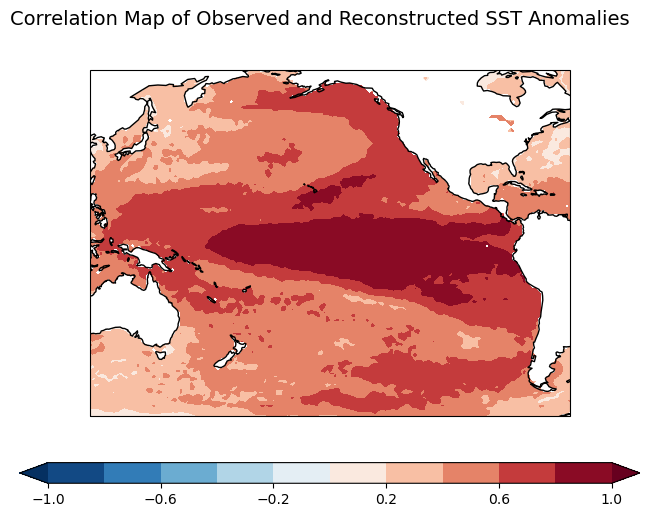

In [54]:
# plot the correlation map
fig = plt.figure(figsize=(8,6))

fig.suptitle('Correlation Map of Observed and Reconstructed SST Anomalies', fontsize=14)

ax = fig.add_subplot(111, projection=projection)
ax.add_feature(cfeature.COASTLINE)
cf = ax.contourf(sst_asds.coords['longitude'].values, sst_asds.coords['latitude'].values, 
                 corrmap, levels=levels, cmap=cmap, transform=crs, extend='both')
cb = fig.colorbar(cf, ax=ax, location='bottom', orientation='horizontal', shrink=1, pad=0.1, aspect=30, ticks=cf.levels[::2])

plt.show()

### Part 6:
- Construct a correplation map between the 1st EOF and monthly mean precipitation anomalies. 
- The precipitation anomalies should be deseasonalized, detrended, and standardized as in Part 2. 

In [55]:
# import non-masked precipitation anomalies
pr_a = xr.open_dataarray('pr.nomsk.anom.monmean.nc').sel(latitude=lat, longitude=lon)

# perform preprocessing steps
pr_asds = preprocess_mon(pr_a)

In [56]:
# select the 1st PC
pc1 = pcs[:,0]

# construct an xarray dataarray
da_pc1 = xr.DataArray(pc1, dims=['time'],
                          coords={'time': sst_asds.coords['time']},)

In [59]:
# compute correlation between EOF1 and the processed precip. anomalies
# the time varying component of EOF1 is the accompaying principal component time series
corrmap_pr = xr.corr(pr_asds, da_reconstructed_sst, dim='time')

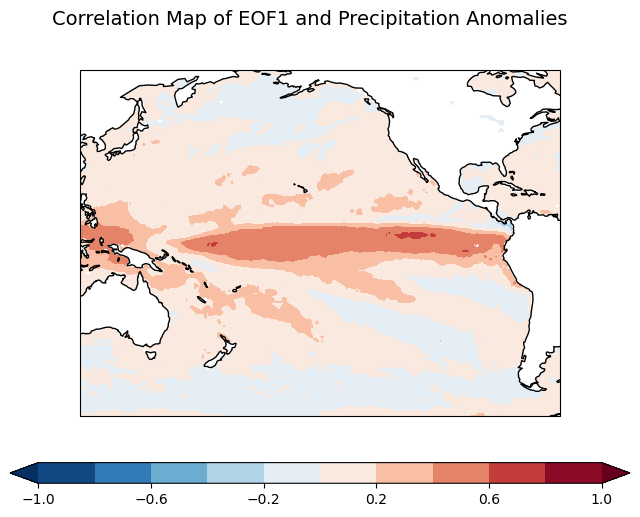

In [60]:
# plot the correlation map
fig = plt.figure(figsize=(8,6))

fig.suptitle('Correlation Map of EOF1 and Precipitation Anomalies', fontsize=14)

ax = fig.add_subplot(111, projection=projection)
ax.add_feature(cfeature.COASTLINE)
cf = ax.contourf(sst_asds.coords['longitude'].values, sst_asds.coords['latitude'].values, 
                 corrmap_pr, levels=levels, cmap=cmap, transform=crs, extend='both')
cb = fig.colorbar(cf, ax=ax, location='bottom', orientation='horizontal', shrink=1, pad=0.1, aspect=30, ticks=cf.levels[::2])

plt.show()

There are several regions that feature high-magnitude, positive correlations. This indicates that the variability of SST within this domain (as captured by the leading EOF) has impacts on precipitation over the tropical Pacific. This particular EOF captures the common eastern Pacific signature of ENSO, which strongly modulates precipitation over regions where SST variability is largest (across the western, eastern, and central Pacific). The response of precipitation is indicative of the nonlinear relationship between SST and precipitation, but the impacts of ENSO on the large-scale atmospheric circulation is a more important factor in determining the remote impacts of ENSO on precipitation, which are not shown on this plot. 